In [1]:
!pip install nibabel

# Dual CNN ADNet

In [2]:
import numpy as np

## Preparing data

In [3]:
import pandas as pd

metadata = '/kaggle/input/adni-processed-complete/ADNI1_Complete_1Yr_1.5T_6_20_2025.csv'
meta = pd.read_csv(metadata)
meta.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/01/2008,NiFTI,NaN
1,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,NiFTI,NaN
2,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,NaN
3,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,NiFTI,NaN
4,I105437,941_S_1202,CN,M,79,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/28/2008,NiFTI,NaN


In [4]:
matching_index = meta[(meta['Image Data ID'] == 'I112538') & (meta['Subject'] == '941_S_1311')].index
matching_index

Index([0], dtype='int64')

In [5]:
meta.shape

(2294, 12)

In [6]:
import os

base_path = "/kaggle/input/adni-processed-complete/ADNI_Processed/ADNI_Processed"

In [7]:
subjects = []
for folder in os.listdir(base_path):
    print(folder)
    for subject in os.listdir(os.path.join(base_path, folder)):
        subjects.append(subject)

subjects = list(set(subjects))
l_s = len(subjects)
print("Total Subjects", l_s)

ADNI1_Complete 1Yr 1.5T8
ADNI1_Complete 1Yr 1.5T1
ADNI1_Complete 1Yr 1.5T6
ADNI1_Complete 1Yr 1.5T4
ADNI1_Complete 1Yr 1.5T9
ADNI1_Complete 1Yr 1.5T3
ADNI1_Complete 1Yr 1.5T5
ADNI1_Complete 1Yr 1.5T2
ADNI1_Complete 1Yr 1.5T
ADNI1_Complete 1Yr 1.5T7
Total Subjects 639


In [8]:
import random

random.shuffle(subjects)
train_subjects = subjects[:int(0.7*l_s)]
val_subjects = subjects[int(0.7*l_s):int(0.8*l_s)]
test_subjects = subjects[int(0.8*l_s):]

In [9]:
train_file_paths = []
val_file_paths = []
test_file_paths = []

train_targets = []
val_targets = []
test_targets = []

for folder in os.listdir(base_path):
    print(folder)
    for subject in os.listdir(os.path.join(base_path, folder)):
        for image in os.listdir(os.path.join(base_path, folder, subject)):
            for file in os.listdir(os.path.join(base_path, folder, subject, image)):
                file_path = os.path.join(folder, subject, image, file)
                target_idx = meta[((meta['Subject'] == subject) & (meta['Image Data ID'] == image))].index
                if subject in train_subjects:
                    train_file_paths.append(file_path)
                    train_targets.append(str(meta.iloc[target_idx[0], 2]))
                elif subject in val_subjects:
                    val_file_paths.append(file_path)
                    val_targets.append(str(meta.iloc[target_idx[0], 2]))
                elif subject in test_subjects:
                    test_file_paths.append(file_path)
                    test_targets.append(str(meta.iloc[target_idx[0], 2]))
                else:
                    print("Error Subject not in any split")

ADNI1_Complete 1Yr 1.5T8
ADNI1_Complete 1Yr 1.5T1
ADNI1_Complete 1Yr 1.5T6
ADNI1_Complete 1Yr 1.5T4
ADNI1_Complete 1Yr 1.5T9
ADNI1_Complete 1Yr 1.5T3
ADNI1_Complete 1Yr 1.5T5
ADNI1_Complete 1Yr 1.5T2
ADNI1_Complete 1Yr 1.5T
ADNI1_Complete 1Yr 1.5T7


In [10]:
print(len(train_file_paths), len(train_targets))
print(len(val_file_paths), len(val_targets))
print(len(test_file_paths), len(test_targets))
# file_paths -> contains paths of all files
# targets -> corresponding targets (in the same order as file_paths)

1600 1600
230 230
464 464


In [11]:
y_data = []
train_files = []
train_len = len(train_file_paths)

for i in range(train_len):
    target = train_targets[i]
    i_file = train_file_paths[i]
    if target=='MCI':
        continue
    elif target=='CN':
        y_data.append(0)
        train_files.append(i_file)
    elif target=='AD':
        y_data.append(1)
        train_files.append(i_file)
    else:
        print('error, ', target)

y_train = np.array(y_data)
print(y_train.shape)
print(len(train_files))

(842,)
842


In [12]:
y_data = []
val_files = []
val_len = len(val_file_paths)

for i in range(val_len):
    target = val_targets[i]
    i_file = val_file_paths[i]
    if target=='MCI':
        continue
    elif target=='CN':
        y_data.append(0)
        val_files.append(i_file)
    elif target=='AD':
        y_data.append(1)
        val_files.append(i_file)
    else:
        print('error, ', target)

y_val = np.array(y_data)
print(y_val.shape)
print(len(val_files))

(116,)
116


In [13]:
y_data = []
test_files = []
test_len = len(test_file_paths)

for i in range(test_len):
    target = test_targets[i]
    i_file = test_file_paths[i]
    if target=='MCI':
        continue
    elif target=='CN':
        y_data.append(0)
        test_files.append(i_file)
    elif target=='AD':
        y_data.append(1)
        test_files.append(i_file)
    else:
        print('error, ', target)

y_test = np.array(y_data)
print(y_test.shape)
print(len(test_files))

(223,)
223


In [14]:
print('CN: ', np.count_nonzero(y_train==0))
print('AD: ', np.count_nonzero(y_train==1))
print('MCI: ', np.count_nonzero(y_train==2))
print(y_train.shape)

CN:  512
AD:  330
MCI:  0
(842,)


In [15]:
print('CN: ', np.count_nonzero(y_val==0))
print('AD: ', np.count_nonzero(y_val==1))
print('MCI: ', np.count_nonzero(y_val==2))
print(y_val.shape)

CN:  72
AD:  44
MCI:  0
(116,)


In [16]:
print('CN: ', np.count_nonzero(y_test==0))
print('AD: ', np.count_nonzero(y_test==1))
print('MCI: ', np.count_nonzero(y_test==2))
print(y_test.shape)

CN:  121
AD:  102
MCI:  0
(223,)


In [17]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# # visualising data
# import nibabel as nib
# import numpy as np
# import matplotlib.pyplot as plt

# file_no = 170

# nii_file = os.path.join(base_path, train_file_paths[file_no])
# img = nib.load(nii_file)
# data = img.get_fdata()

# print("Shape:", data.shape)

# def show_slices(slices):
#     fig, axes = plt.subplots(1, len(slices), figsize=(15, 5))
#     print('Type: ', train_targets[file_no])
#     for i, slice in enumerate(slices):
#         axes[i].imshow(slice.T, cmap="gray", origin="lower")
#     plt.tight_layout()
#     plt.show()

# # Select central slices from axial, sagittal, coronal planes
# sagittal = data[data.shape[0] // 2, :, :]
# coronal  = data[:, data.shape[1] // 2, :]
# axial    = data[:, :, data.shape[2] // 2]

# show_slices([sagittal, coronal, axial])

In [19]:
# import torch
# from torch.utils.data import DataLoader, Dataset

# class MRIData(Dataset):
#     def __init__(self, X_path, y):
#         self.base_path = "/kaggle/input/adni-processed-complete/ADNI_Processed/ADNI_Processed"
#         self.X_path = X_path
#         self.y = y

#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         nii_path = os.path.join(self.base_path, self.X_path[idx])
#         data = nib.load(nii_path).get_fdata()
#         X = data[:, :, data.shape[2] // 2]    # axial central slice
#         X = torch.from_numpy(X.astype(np.float32)).unsqueeze(0)
#         y = torch.tensor(self.y[idx], dtype=torch.long)
#         return X, y


In [20]:
# train_dataset = MRIData(train_files, y_train)
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

In [21]:
# for img, label in train_loader:
#     print("Image shape:", img.shape)         # Should be [1, H, W]
#     print("Label:", label.item())          # Scalar label
#     print("As NumPy array:", img.squeeze(0).numpy().shape)  # Convert to NumPy array (H, W)
#     break  # just get one example

In [22]:
# from torch.utils.data import WeightedRandomSampler

# BATCH_SIZE = 32

# train_dataset = MRIData(train_files, y_train)

# # weighted samplnig (to prevent class imbalance)
# class_sample_count = np.array([sum(y_train == t) for t in [0, 1]])
# weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in y_train])
# samples_weight = torch.from_numpy(samples_weight).float()
# sampler = WeightedRandomSampler(samples_weight, len(samples_weight))


# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)

# # no need for weighted sampling of val and test sets
# val_dataset = MRIData(val_files, y_val)
# test_dataset = MRIData(test_files, y_test)

# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [23]:
# import torch
# import torch.nn as nn
# import torch.functional as F
# import torch.optim as optim
# from torch.utils.data import DataLoader

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

In [24]:
# class cnn1(nn.Module):
#     def __init__(self, kernel_size=3, dropout_rate=0.2, in_channels=1):
#         super(cnn1, self).__init__()

#         self.K = kernel_size
#         self.in_channels = in_channels
#         self.dropout_rate = dropout_rate

#         self.net = nn.Sequential(
#             nn.Conv2d(self.in_channels, 16, kernel_size=self.K, padding=1),
#             nn.ReLU(),

#             nn.Conv2d(16, 16, kernel_size=self.K, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(16, 64, kernel_size=self.K, padding=1),
#             nn.ReLU(),

#             nn.Conv2d(64, 64, kernel_size=self.K, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(64, 256, kernel_size=self.K, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.Dropout2d(self.dropout_rate),
#             nn.Flatten(),
#             nn.Linear(262144, 128)
#         )

#     def forward(self, x):
#         x = self.net(x)
#         return x


In [25]:
# class cnn2(nn.Module):
#     def __init__(self, kernel_size=5, dropout_rate=0.2, in_channels=1):
#         super(cnn2, self).__init__()

#         self.K = kernel_size
#         self.in_channels = in_channels
#         self.dropout_rate = dropout_rate

#         self.net = nn.Sequential(
#             nn.Conv2d(self.in_channels, 32, kernel_size=self.K, padding=1),
#             nn.ReLU(),

#             nn.Conv2d(32, 32, kernel_size=self.K, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(32, 128, kernel_size=self.K, padding=1),
#             nn.ReLU(),

#             nn.Conv2d(128, 128, kernel_size=self.K, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(128, 512, kernel_size=self.K, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.Dropout2d(self.dropout_rate),
#             nn.Flatten(),
#             nn.Linear(430592, 128)
#         )

#     def forward(self, x):
#         x = self.net(x)
#         return x


In [26]:
# class ADNet(nn.Module):
#     def __init__(self, input_dim=224, dropout_rate=0.2, in_channels=1, n_labels=2):
#         super(ADNet, self).__init__()

#         self.input_dim = input_dim
#         self.dropout_rate = dropout_rate
#         self.in_channels = in_channels
#         self.n_labels = n_labels

#         self.cnn1 = cnn1(dropout_rate=self.dropout_rate, in_channels=self.in_channels)
#         self.cnn2 = cnn2(dropout_rate=self.dropout_rate, in_channels=self.in_channels)

#         self.classifier = nn.Sequential(
#             nn.Linear(128 + 128, 128),
#             nn.ReLU(),
#             nn.Dropout(self.dropout_rate),
#             nn.Linear(128, self.n_labels)   # final layer for binary classification
#         )

#     def forward(self, x):
#         x1 = self.cnn1(x)   # shape: (B, 128)
#         x2 = self.cnn2(x)   # shape: (B, 128)

#         x = torch.cat((x1, x2), dim=1)  # concatenate features from both CNNs, shape: (B, 256)
#         x = self.classifier(x)          # shape: (B, 1)
#         return x


In [27]:
# # testing dimensions
# model = ADNet()
# input_tensor = torch.randn(8, 1, 256, 256)  # batch of 8 single-channel images
# output = model(input_tensor)               # output shape: (8, n_labels)
# print(output.shape)  # should print torch.Size([8, n_labels]) for classification
# # print(model)  # print the model architecture

## Training

In [28]:
# # training
# model = ADNet()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     model = torch.nn.DataParallel(model)

# model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [29]:
# # train loop
# def train_epoch(model, dataloader, optimizer, criterion):
#   model.train()
#   current_loss = 0.0
#   correct, total = 0, 0

#   for inputs, targets in dataloader:
#     inputs, targets = inputs.to(device), targets.to(device)

#     optimizer.zero_grad()
#     outputs = model(inputs)
#     loss = criterion(outputs, targets)
#     loss.backward()
#     optimizer.step()

#     current_loss += loss.item() * inputs.size(0)
#     _, predicted = outputs.max(1)
#     correct += predicted.eq(targets).sum().item()
#     total += targets.size(0)

#   avg_loss = current_loss / total
#   accuracy = correct / total

#   return avg_loss, accuracy

In [30]:
# # evaluation loop
# def evaluate(model, dataloader, criterion):
#   model.eval()
#   current_loss = 0.0
#   correct, total = 0, 0

#   with torch.no_grad():
#     for inputs, targets in dataloader:
#       inputs, targets = inputs.to(device), targets.to(device)
#       outputs = model(inputs)
#       loss = criterion(outputs, targets)

#       current_loss += loss.item() * inputs.size(0)
#       _, predicted = outputs.max(1)
#       correct += predicted.eq(targets).sum().item()
#       total += targets.size(0)

#   avg_loss = current_loss / total
#   accuracy = correct / total

#   return avg_loss, accuracy

In [31]:
# # training loop
# def train_model(model, train_loader, val_loader, epochs=10):
#     train_loss_list = []
#     train_acc_list = []
#     val_loss_list = []
#     val_acc_list = []
#     for epoch in range(epochs):
#         train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
#         val_loss, val_acc = evaluate(model, val_loader, criterion)
#         train_loss_list.append(train_loss)
#         train_acc_list.append(train_acc)
#         val_loss_list.append(val_loss)
#         val_acc_list.append(val_acc)
    
#         print(f"Epoch {epoch+1}/{epochs}")
#         print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")
#         print(f"  Val   Loss: {val_loss:.4f}, Accuracy: {val_acc*100:.2f}%\n")
    
#     return (train_loss_list, train_acc_list, val_loss_list, val_acc_list)

In [32]:
# history = train_model(model, train_loader, val_loader, epochs=10)

In [33]:
# train_loss, train_acc, val_loss, val_acc = history
# epochs = range(1, len(train_loss) + 1)

# plt.figure(figsize=(12, 5))

# # Plot Loss
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
# plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
# plt.title('Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

# # Plot Accuracy
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
# plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
# plt.title('Accuracy over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [34]:
# torch.save(model.state_dict(), "adnet_1_fulldata.pth")

In [35]:
# print(os.path.exists("/kaggle/working/adnet_1_fulldata.pth"))

In [36]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ADNet()

# # Load and fix state_dict
# from collections import OrderedDict
# model_path= "/kaggle/working/adnet_1_fulldata.pth"
# state_dict = torch.load(model_path, map_location=device)
# new_state_dict = OrderedDict((k.replace('module.', ''), v) for k, v in state_dict.items())

# model.load_state_dict(new_state_dict)
# model.to(device)


# def save_outputs(model, dataloader):
#     model.eval()
#     preds = []
#     labels = []
#     correct, total = 0, 0

#     with torch.no_grad():
#         for inputs, targets in dataloader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = model(inputs)

#             _, predicted = outputs.max(1)
#             preds.extend(predicted.cpu().tolist())  # Detach and move to CPU
#             labels.extend(targets.cpu().tolist())

#             correct += predicted.eq(targets).sum().item()
#             total += targets.size(0)

#     accuracy = correct / total
#     return accuracy, preds, labels

In [37]:
# from sklearn.metrics import (
#     confusion_matrix,
#     ConfusionMatrixDisplay,
#     classification_report,
#     accuracy_score,
#     f1_score,
#     precision_score,
#     recall_score
# )
# import matplotlib.pyplot as plt

# # Evaluate the model
# accuracy, preds, labels = save_outputs(model, train_loader)
# # Confusion Matrix
# cm = confusion_matrix(labels, preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title("Confusion Matrix")
# plt.show()

# # Classification Report
# print("=== Classification Report ===")
# print(classification_report(labels, preds, digits=4))


# overall_acc = accuracy_score(labels, preds)
# macro_f1    = f1_score(labels, preds, average='macro')
# micro_f1    = f1_score(labels, preds, average='micro')
# weighted_f1 = f1_score(labels, preds, average='weighted')
# precision   = precision_score(labels, preds, average='macro')
# recall      = recall_score(labels, preds, average='macro')

# print("\n=== Summary Metrics ===")
# print(f"Accuracy     : {overall_acc:.4f}")
# print(f"Macro F1     : {macro_f1:.4f}")
# print(f"Micro F1     : {micro_f1:.4f}")
# print(f"Weighted F1  : {weighted_f1:.4f}")
# print(f"Precision    : {precision:.4f}")
# print(f"Recall       : {recall:.4f}")

## Testing on external data

In [38]:
# for folder in os.listdir(base_path_t):
#     print(folder)
#     for subject in os.listdir(os.path.join(base_path_t, folder)):
#         for image in os.listdir(os.path.join(base_path_t, folder, subject)):
#             for file in os.listdir(os.path.join(base_path_t, folder, subject, image)):
#                 file_path_t = os.path.join(folder, subject, image, file)
#                 file_paths_t.append(file_path_t)
#                 target_idx = meta_t[((meta_t['Subject'] == subject) & (meta_t['Image Data ID'] == image))].index
#                 targets_t.append(str(meta_t.iloc[target_idx[0], 2]))


In [39]:
# import pandas as pd
# import os
# import numpy as np

# metadata_test = '/kaggle/input/testing-adni/ADNI1_Complete_1Yr_3T_7_07_2025.csv'  #<---
# meta_t = pd.read_csv(metadata_test)
# # meta.head()

# base_path_t = "/kaggle/input/testing-adni/ADNI_1Yr_3T_Processed" #<---
# file_paths_t = []
# targets_t = []

# for folder in os.listdir(base_path_t):
#     print(folder)
#     for subject in os.listdir(os.path.join(base_path_t, folder)):
#         for image in os.listdir(os.path.join(base_path_t, folder, subject)):
#             for file in os.listdir(os.path.join(base_path_t, folder, subject, image)):
#                 file_path_t = os.path.join(folder, subject, image, file)
#                 file_paths_t.append(file_path_t)
#                 target_idx = meta_t[((meta_t['Subject'] == subject) & (meta_t['Image Data ID'] == image))].index
#                 targets_t.append(str(meta_t.iloc[target_idx[0], 2]))


# y_data_t = []

# for target in targets_t:
#     if target=='MCI':
#         y_data_t.append(2)
#     elif target=='CN':
#         y_data_t.append(0)
#     elif target=='AD':
#         y_data_t.append(1)
#     else:
#         print('error, ', target)

# y_t = np.array(y_data_t)
# print(y_t.shape)

# dataset_t = MRIData(file_paths_t, y_t)
# loader_t = DataLoader(dataset_t, batch_size=1, shuffle=False)

# # Using only the AD and CN data:
# new_data_paths_t = []
# new_y_t = []

# for i in range(len(y_t)):
#     if (y_t[i] == 2):
#         continue
#     new_data_paths_t.append(file_paths_t[i])
#     new_y_t.append(y_t[i])

# from torch.utils.data import WeightedRandomSampler

# BATCH_SIZE = 32

# test_dataset_t = MRIData(new_data_paths_t, new_y_t)
# test_loader_t = DataLoader(test_dataset_t, batch_size=BATCH_SIZE, shuffle=False)

In [40]:
# from sklearn.metrics import (
#     confusion_matrix,
#     ConfusionMatrixDisplay,
#     classification_report,
#     accuracy_score,
#     f1_score,
#     precision_score,
#     recall_score
# )
# import matplotlib.pyplot as plt

# # Evaluate the model
# accuracy, preds, labels = save_outputs(model, test_loader_t)

# # Confusion Matrix
# cm = confusion_matrix(labels, preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title("Confusion Matrix")
# plt.show()

# # Classification Report
# print("=== Classification Report ===")
# print(classification_report(labels, preds, digits=4))


# overall_acc = accuracy_score(labels, preds)
# macro_f1    = f1_score(labels, preds, average='macro')
# micro_f1    = f1_score(labels, preds, average='micro')
# weighted_f1 = f1_score(labels, preds, average='weighted')
# precision   = precision_score(labels, preds, average='macro')
# recall      = recall_score(labels, preds, average='macro')

# print("\n=== Summary Metrics ===")
# print(f"Accuracy     : {overall_acc:.4f}")
# print(f"Macro F1     : {macro_f1:.4f}")
# print(f"Micro F1     : {micro_f1:.4f}")
# print(f"Weighted F1  : {weighted_f1:.4f}")
# print(f"Precision    : {precision:.4f}")
# print(f"Recall       : {recall:.4f}")

-------------
-------------

# Weighted Dual CNN model

## Preparing tha data

In [41]:
import torch
from torch.utils.data import DataLoader, Dataset

class MRIData_W(Dataset):
    def __init__(self, X_path, y):
        self.base_path = "/kaggle/input/adni-processed-complete/ADNI_Processed/ADNI_Processed"
        self.X_path = X_path
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        nii_path = os.path.join(self.base_path, self.X_path[idx])
        data = nib.load(nii_path).get_fdata()
        X1 = data[:, :, data.shape[2] // 2]    # axial central slice
        X1 = torch.from_numpy(X1.astype(np.float32)).unsqueeze(0)
        X2 = data[:, data.shape[2] // 2, :]    # __ central slice
        X2 = torch.from_numpy(X2.astype(np.float32)).unsqueeze(0)
        X3 = data[data.shape[2] // 2, :, :]    # ___ central slice
        X3 = torch.from_numpy(X3.astype(np.float32)).unsqueeze(0)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return X1, X2, X3, y

In [42]:
from torch.utils.data import WeightedRandomSampler

BATCH_SIZE = 32

train_dataset = MRIData_W(train_files, y_train)

# weighted samplnig (to prevent class imbalance)
class_sample_count = np.array([sum(y_train == t) for t in [0, 1]])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight).float()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)

# no need for weighted sampling of val and test sets
val_dataset = MRIData_W(val_files, y_val)
test_dataset = MRIData_W(test_files, y_test)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [43]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [44]:
class cnn1(nn.Module):
    def __init__(self, kernel_size=3, dropout_rate=0.2, in_channels=1):
        super(cnn1, self).__init__()

        self.K = kernel_size
        self.in_channels = in_channels
        self.dropout_rate = dropout_rate

        self.net = nn.Sequential(
            nn.Conv2d(self.in_channels, 16, kernel_size=self.K, padding=1),
            nn.ReLU(),

            nn.Conv2d(16, 16, kernel_size=self.K, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 64, kernel_size=self.K, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=self.K, padding=1),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),   # added
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 256, kernel_size=self.K, padding=1),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),   # added
            nn.MaxPool2d(2, 2),

            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),  
            nn.Flatten(),
            nn.Linear(262144, 128)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [45]:
class cnn2(nn.Module):
    def __init__(self, kernel_size=5, dropout_rate=0.2, in_channels=1):
        super(cnn2, self).__init__()

        self.K = kernel_size
        self.in_channels = in_channels
        self.dropout_rate = dropout_rate

        self.net = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=self.K, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 32, kernel_size=self.K, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 128, kernel_size=self.K, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=self.K, padding=1),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),   # added
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 512, kernel_size=self.K, padding=1),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),   # added
            nn.MaxPool2d(2, 2),

            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_rate),
            nn.Flatten(),
            nn.Linear(430592, 128)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [68]:
class TwinCNN(nn.Module):
    def __init__(self):
        super(TwinCNN, self).__init__()
        
        self.cnn1 = cnn1(dropout_rate= 0.0)   # can change hyper params here
        self.cnn2 = cnn2(dropout_rate= 0.0)

    def forward(self, x):
        out1 = self.cnn1(x) # (B, 128)
        out2 = self.cnn2(x) # (B, 128)
        return torch.cat([out1, out2], dim=1)  # (B, 256)

In [69]:
class W_ThreeHeadedADNet(nn.Module):
    def __init__(self, n_labels=2):
        super(W_ThreeHeadedADNet, self).__init__()

        self.head1 = TwinCNN()
        self.head2 = TwinCNN()
        self.head3 = TwinCNN()
        self.n_labels = n_labels

        # Learnable attention weights for 3 heads
        self.attention_weights = nn.Parameter(torch.ones(3))  # initialized as [1.0, 1.0, 1.0]

        self.classifier = nn.Sequential(
            nn.Linear(256 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, n_labels)
        )

    def forward(self, x1, x2, x3):
        h1 = self.head1(x1)  # shape: (B, 256)
        h2 = self.head2(x2)  # shape: (B, 256)
        h3 = self.head3(x3)  # shape: (B, 256)

        # Apply softmax to get normalized attention weights
        alpha = torch.softmax(self.attention_weights, dim=0)  # shape: [3]

        # Weight each feature vector
        h1 = alpha[0] * h1
        h2 = alpha[1] * h2
        h3 = alpha[2] * h3

        # Concatenate weighted features
        fused = torch.cat([h1, h2, h3], dim=1)  # shape: (B, 768)

        return self.classifier(fused)  # shape: (B, n_labels)

In [70]:
# testing dimensions
model = W_ThreeHeadedADNet()
input_tensor = torch.randn(8, 1, 256, 256)  # batch of 8 single-channel images
output = model(input_tensor, input_tensor, input_tensor)               # output shape: (8, n_labels)
print(output.shape)  # should print torch.Size([8, n_labels]) for classification
# print(model)  # print the model architecture

torch.Size([8, 2])


# Training

In [71]:
# training
model = W_ThreeHeadedADNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using 2 GPUs


In [72]:
# train loop
def train_epoch(model, dataloader, optimizer, criterion):
  model.train()
  current_loss = 0.0
  correct, total = 0, 0

  for data1, data2, data3, targets in dataloader:
    data1, data2, data3, targets = data1.to(device), data2.to(device), data3.to(device), targets.to(device)

    optimizer.zero_grad()
    outputs = model(data1, data2, data3)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    current_loss += loss.item() * targets.size(0)
    _, predicted = outputs.max(1)
    correct += predicted.eq(targets).sum().item()
    total += targets.size(0)

  avg_loss = current_loss / total
  accuracy = correct / total

  return avg_loss, accuracy

In [73]:
# evaluation loop
def evaluate(model, dataloader, criterion):
  model.eval()
  current_loss = 0.0
  correct, total = 0, 0

  with torch.no_grad():
    for data1, data2, data3, targets in dataloader:
      data1, data2, data3, targets = data1.to(device), data2.to(device), data3.to(device), targets.to(device)
      outputs = model(data1, data2, data3)
      loss = criterion(outputs, targets)

      current_loss += loss.item() * targets.size(0)
      _, predicted = outputs.max(1)
      correct += predicted.eq(targets).sum().item()
      total += targets.size(0)

  avg_loss = current_loss / total
  accuracy = correct / total

  return avg_loss, accuracy

In [74]:
# training loop
def train_model(model, train_loader, val_loader, epochs=10):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")
        print(f"  Val   Loss: {val_loss:.4f}, Accuracy: {val_acc*100:.2f}%\n")
    
    return (train_loss_list, train_acc_list, val_loss_list, val_acc_list)

In [ ]:
history = train_model(model, train_loader, val_loader, epochs=20)

Epoch 1/20
  Train Loss: 1.3436, Accuracy: 53.21%
  Val   Loss: 0.6385, Accuracy: 63.79%

Epoch 2/20
  Train Loss: 0.4994, Accuracy: 77.20%
  Val   Loss: 0.8007, Accuracy: 43.10%

Epoch 3/20
  Train Loss: 0.2940, Accuracy: 90.86%
  Val   Loss: 0.5478, Accuracy: 67.24%

Epoch 4/20
  Train Loss: 0.1231, Accuracy: 98.46%
  Val   Loss: 0.5114, Accuracy: 74.14%

Epoch 5/20
  Train Loss: 0.0634, Accuracy: 99.41%
  Val   Loss: 0.7352, Accuracy: 71.55%

Epoch 6/20
  Train Loss: 0.0322, Accuracy: 99.52%
  Val   Loss: 0.5898, Accuracy: 69.83%

Epoch 7/20
  Train Loss: 0.0103, Accuracy: 100.00%
  Val   Loss: 0.5767, Accuracy: 70.69%

Epoch 8/20
  Train Loss: 0.0051, Accuracy: 100.00%
  Val   Loss: 0.7872, Accuracy: 75.00%

Epoch 9/20
  Train Loss: 0.0027, Accuracy: 100.00%
  Val   Loss: 0.6306, Accuracy: 72.41%

Epoch 10/20
  Train Loss: 0.0017, Accuracy: 100.00%
  Val   Loss: 0.6345, Accuracy: 70.69%

Epoch 11/20
  Train Loss: 0.0015, Accuracy: 100.00%
  Val   Loss: 0.7892, Accuracy: 75.86%

Epo

In [67]:
torch.save(model.state_dict(), "model_3_V1.pth")

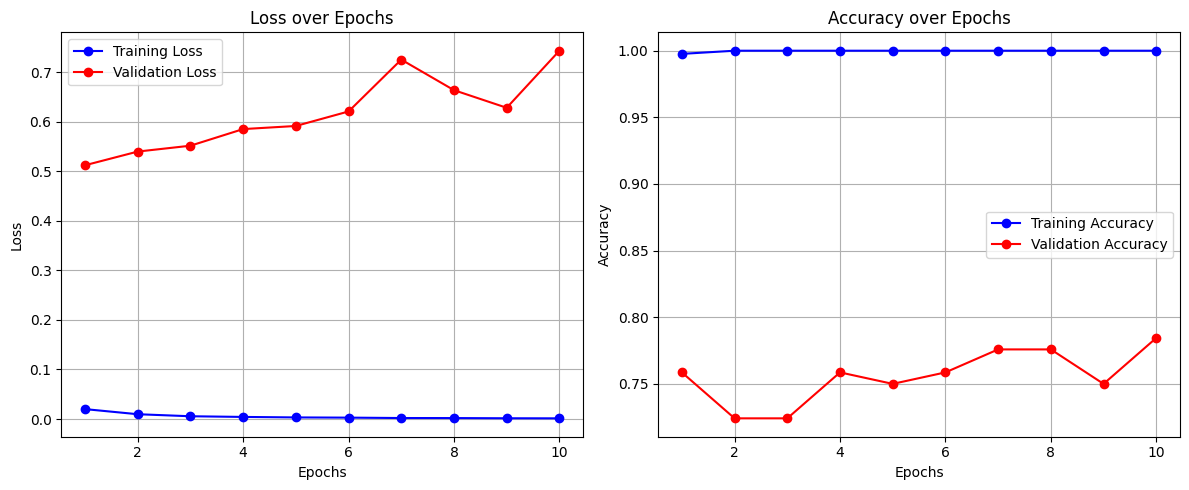

In [63]:
train_loss, train_acc, val_loss, val_acc = history
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluation

In [64]:
def save_outputs_W(model, dataloader):
    model.eval()
    preds = []
    labels = []
    correct, total = 0, 0

    with torch.no_grad():
        for data1, data2, data3, targets in dataloader:
            data1, data2, data3, targets = data1.to(device), data2.to(device), data3.to(device), targets.to(device)
            outputs = model(data1, data2, data3)

            _, predicted = outputs.max(1)
            preds.extend(predicted.cpu().tolist())  # Detach and move to CPU
            labels.extend(targets.cpu().tolist())

            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy, preds, labels

In [65]:
# evaluation loop
def evaluate(model, dataloader, criterion):
  model.eval()
  current_loss = 0.0
  correct, total = 0, 0

  with torch.no_grad():
    for data1, data2, data3, targets in dataloader:
      data1, data2, data3, targets = data1.to(device), data2.to(device), data3.to(device), targets.to(device)
      outputs = model(data1, data2, data3)
      loss = criterion(outputs, targets)

      current_loss += loss.item() * targets.size(0)
      _, predicted = outputs.max(1)
      correct += predicted.eq(targets).sum().item()
      total += targets.size(0)

  avg_loss = current_loss / total
  accuracy = correct / total

  return avg_loss, accuracy

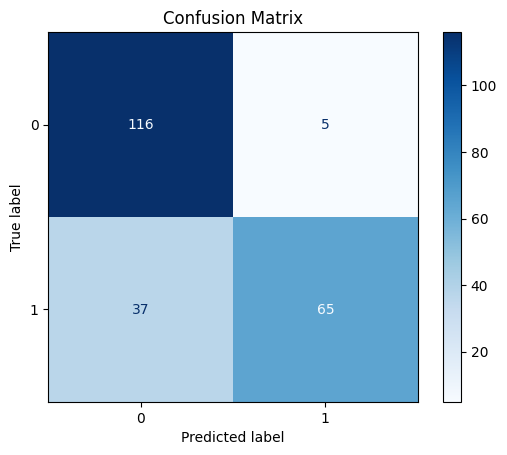

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7582    0.9587    0.8467       121
           1     0.9286    0.6373    0.7558       102

    accuracy                         0.8117       223
   macro avg     0.8434    0.7980    0.8013       223
weighted avg     0.8361    0.8117    0.8051       223


=== Summary Metrics ===
Accuracy     : 0.8117
Macro F1     : 0.8013
Micro F1     : 0.8117
Weighted F1  : 0.8051
Precision    : 0.8434
Recall       : 0.7980


In [66]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt

# Evaluate the model
accuracy, preds, labels = save_outputs_W(model, test_loader)

# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("=== Classification Report ===")
print(classification_report(labels, preds, digits=4))


overall_acc = accuracy_score(labels, preds)
macro_f1    = f1_score(labels, preds, average='macro')
micro_f1    = f1_score(labels, preds, average='micro')
weighted_f1 = f1_score(labels, preds, average='weighted')
precision   = precision_score(labels, preds, average='macro')
recall      = recall_score(labels, preds, average='macro')

print("\n=== Summary Metrics ===")
print(f"Accuracy     : {overall_acc:.4f}")
print(f"Macro F1     : {macro_f1:.4f}")
print(f"Micro F1     : {micro_f1:.4f}")
print(f"Weighted F1  : {weighted_f1:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")

0.3, 0.3(just last layer)

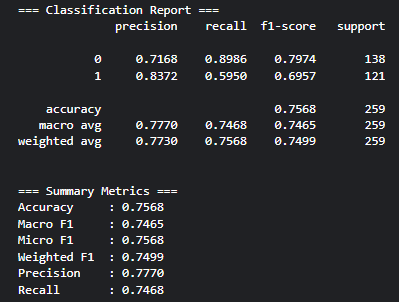

0.3, 0.4(just last layer)

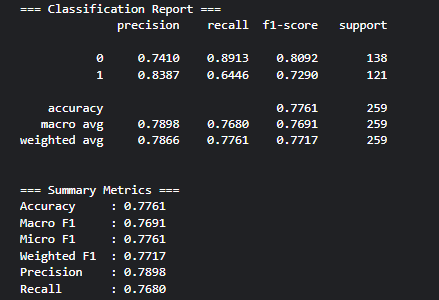

0.1, 0.1(last 3)

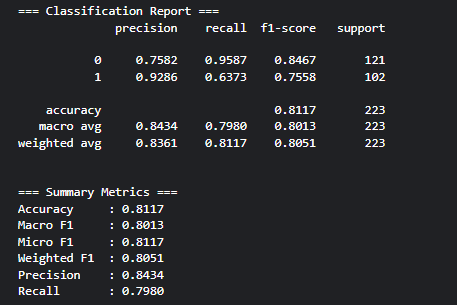

# Testing on unseen data

In [ ]:
base_path_t = "/kaggle/input/testing-adni/ADNI_1Yr_3T_Processed"
metadata_test = '/kaggle/input/testing-adni/ADNI1_Complete_1Yr_3T_7_07_2025.csv'
model_path= "/kaggle/working/three_headed_ADNet1_V2.pth"

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset

class MRIData_W_t(Dataset):
    def __init__(self, X_path, y):
        self.base_path = base_path_t
        self.X_path = X_path
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        nii_path = os.path.join(self.base_path, self.X_path[idx])
        data = nib.load(nii_path).get_fdata()
        X1 = data[:, :, data.shape[2] // 2]    # axial central slice
        X1 = torch.from_numpy(X1.astype(np.float32)).unsqueeze(0)
        X2 = data[:, data.shape[2] // 2, :]    # __ central slice
        X2 = torch.from_numpy(X2.astype(np.float32)).unsqueeze(0)
        X3 = data[data.shape[2] // 2, :, :]    # ___ central slice
        X3 = torch.from_numpy(X3.astype(np.float32)).unsqueeze(0)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return X1, X2, X3, y

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = W_ThreeHeadedADNet()

# Load and fix state_dict
from collections import OrderedDict
model_path= model_path
state_dict = torch.load(model_path, map_location=device)
new_state_dict = OrderedDict((k.replace('module.', ''), v) for k, v in state_dict.items())

model.load_state_dict(new_state_dict)
model.to(device)


def save_outputs_W(model, dataloader):
    model.eval()
    preds = []
    labels = []
    correct, total = 0, 0

    with torch.no_grad():
        for data1, data2, data3, targets in dataloader:
            data1, data2, data3, targets = data1.to(device), data2.to(device), data3.to(device), targets.to(device)
            outputs = model(data1, data2, data3)

            _, predicted = outputs.max(1)
            preds.extend(predicted.cpu().tolist())  # Detach and move to CPU
            labels.extend(targets.cpu().tolist())

            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy, preds, labels

In [ ]:
import pandas as pd
import os
import numpy as np

metadata_test = metadata_test  #<---
meta_t = pd.read_csv(metadata_test)

base_path_t = base_path_t #<---
file_paths_t = []
targets_t = []

for folder in os.listdir(base_path_t):
    print(folder)
    for subject in os.listdir(os.path.join(base_path_t, folder)):
        for image in os.listdir(os.path.join(base_path_t, folder, subject)):
            for file in os.listdir(os.path.join(base_path_t, folder, subject, image)):
                file_path_t = os.path.join(folder, subject, image, file)
                file_paths_t.append(file_path_t)
                target_idx = meta_t[((meta_t['Subject'] == subject) & (meta_t['Image Data ID'] == image))].index
                targets_t.append(str(meta_t.iloc[target_idx[0], 2]))


y_data_t = []

for target in targets_t:
    if target=='MCI':
        y_data_t.append(2)
    elif target=='CN':
        y_data_t.append(0)
    elif target=='AD':
        y_data_t.append(1)
    else:
        print('error, ', target)

y_t = np.array(y_data_t)
print(y_t.shape)

dataset_t = MRIData_W_t(file_paths_t, y_t)
loader_t = DataLoader(dataset_t, batch_size=1, shuffle=False)

# Using only the AD and CN data:
new_data_paths_t = []
new_y_t = []

for i in range(len(y_t)):
    if (y_t[i] == 2):
        continue
    new_data_paths_t.append(file_paths_t[i])
    new_y_t.append(y_t[i])

from torch.utils.data import WeightedRandomSampler

BATCH_SIZE = 32

test_dataset_t = MRIData_W_t(new_data_paths_t, new_y_t)
test_loader_t = DataLoader(test_dataset_t, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt

# Evaluate the model
accuracy, preds, labels = save_outputs_W(model, test_loader_t)

# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("=== Classification Report ===")
print(classification_report(labels, preds, digits=4))


overall_acc = accuracy_score(labels, preds)
macro_f1    = f1_score(labels, preds, average='macro')
micro_f1    = f1_score(labels, preds, average='micro')
weighted_f1 = f1_score(labels, preds, average='weighted')
precision   = precision_score(labels, preds, average='macro')
recall      = recall_score(labels, preds, average='macro')

print("\n=== Summary Metrics ===")
print(f"Accuracy     : {overall_acc:.4f}")
print(f"Macro F1     : {macro_f1:.4f}")
print(f"Micro F1     : {micro_f1:.4f}")
print(f"Weighted F1  : {weighted_f1:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")